# Testing data analysis scripts of a run

In case you only have the h5 files and not the .json

In [1]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()
import time
import sys

In [2]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [3]:
img_name = 'SilverBehenate_powderCalibration'
h5path = '/sf/bernina/data/p17743/raw/%s.JF07T32V01.h5' % img_name
h5file = h5py.File(h5path,'r')
jf7 = h5file['data/JF07T32V01/data']
with h5py.File('/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5','r') as f:
    gains = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/waterJet_tests/JFpedestal/pedestal_20190125_1507.JF07T32V01.res.h5','r') as f:
    pede = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5','r') as f:
    noise = f['gainsRMS'].value
    mask = f['pixel_mask'].value

In [4]:
n_shots = 10
icorr = apply_gain_pede(jf7[0],G=gains, P=pede, pixel_mask=mask)
icorr_geom = apply_geometry(icorr,'JF07T32V01')
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
icorr_geom[mask_geom] = 0#np.nan
avg_img = icorr_geom

In [5]:
bi,bf,db = -2,35,.01
bins = np.arange(bi-db/2.,bf+db/2.,db)
hy,hx = np.histogram(avg_img,bins=bins)
hy_avg = hy
for i in range(1,n_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7[i],G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    icorr_geom[mask_geom] = 0
    avg_img+= icorr_geom
    hy,hx = np.histogram(avg_img[~mask_geom],bins=bins)
    hy_avg += hy
    print('s.%i, %.1f Hz'%(i, 1.0/(time.time() - t1)))
avg_img/=n_shots

hx = np.array([(hx[j]+hx[j+1])/2. for j in range(len(hx)-1)])
hy = np.array(hy,dtype=float)/float(len(bins)*n_shots)
#hy_avg[np.int(-bi/db)-1] += mask_geom.sum()*n_shots

s.1, 0.5 Hz
s.2, 0.5 Hz
s.3, 0.5 Hz
s.4, 0.5 Hz
s.5, 0.5 Hz
s.6, 0.5 Hz
s.7, 0.5 Hz
s.8, 0.5 Hz
s.9, 0.5 Hz


In [6]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.imshow(avg_img,aspect='auto',clim=[0,30])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(avg_img[1800:2600,1800:2400],aspect='auto',clim=[0,30])
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


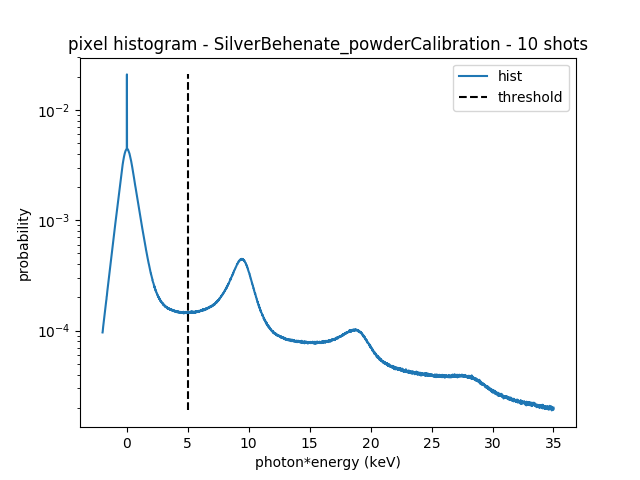

In [15]:
normalization = avg_img[~mask_geom].shape[0]*n_shots
i_threshold = 5 # keV
plt.figure()
plt.title('pixel histogram - %s - %d shots' % (img_name, n_shots))
plt.plot(hx,hy_avg/normalization, label='hist')
plt.yscale('log',nonposy='clip')
plt.ylabel('probability')
plt.xlabel('photon*energy (keV)')
plt.vlines(i_threshold,(hy_avg/normalization).min(),(hy_avg/normalization).max(),color='k',linestyles='dashed',label='threshold')
plt.legend()
plt.savefig('%s_pixel_histogram.png' % img_name)
plt.show()

In [77]:
n_shots=1000
icorr = apply_gain_pede(jf7[0],G=gains, P=pede, pixel_mask=mask)
icorr_geom = apply_geometry(icorr,'JF07T32V01')
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
icorr_geom[mask_geom] = 0 #np.nan
icorr_sum = icorr_geom
avg_img = np.zeros_like(icorr_geom)
mask_inv = np.logical_not(mask_geom) #inversed: 0 masked, 1 not masked  
iq_threshold = 7.5
hits = 0

# initialise for angular integration                                        
rad_dist = radial_distances(icorr_geom)
ra = RadialAverager(rad_dist, mask_inv, n_bins=1001)
r  = ra.bin_centers
iq = ra(icorr_geom)
iqs = np.zeros((n_shots, iq.shape[0]))
iqs[0] = iq

# define ROI for AgBe rings to minimize background
center = (avg_img.shape[0]/2., avg_img.shape[1]/2.)
d1 = (2232, 2223) # min ring
d2 = (2430, 2227) # max ring
r_min = np.sqrt((center[0]-d1[0])**2 + (center[1]-d1[1])**2)
r_max = np.sqrt((center[0]-d2[0])**2 + (center[1]-d2[1])**2)
roi = np.where((r > r_min) & (r < r_max))
if iq[roi].mean() > iq_threshold:
    avg_img += icorr_geom
    hits += 1

for i in range(1,n_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7[i],G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    icorr_geom[mask_geom] = 0
    icorr_geom[icorr_geom < i_threshold] = 0 # remove noise less than half a photon
    icorr_sum += icorr_geom
    iq = ra(icorr_geom)
    iqs[i] = iq
    if iq[roi].mean() > iq_threshold:
        avg_img += icorr_geom
        hits += 1
        print('s.%i, %.1f Hz: %.2f photon/pix: HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
    else:
        print('s.%i, %.1f Hz: %.2f photon/pix' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
avg_img /= hits
icorr_sum /= n_shots
print('DONE! hitrate: %.1f%%' % (100*hits/n_shots))

s.2, 1.9 Hz: 0.10 photon/pix
s.3, 1.9 Hz: 0.10 photon/pix
s.4, 2.0 Hz: 0.10 photon/pix
s.5, 2.0 Hz: 0.10 photon/pix
s.6, 2.0 Hz: 0.09 photon/pix
s.7, 2.1 Hz: 0.06 photon/pix
s.8, 2.1 Hz: 0.09 photon/pix
s.9, 2.1 Hz: 0.09 photon/pix
s.10, 2.0 Hz: 0.11 photon/pix
s.11, 2.0 Hz: 0.08 photon/pix
s.12, 2.0 Hz: 0.11 photon/pix
s.13, 2.1 Hz: 0.06 photon/pix
s.14, 2.0 Hz: 0.09 photon/pix
s.15, 2.1 Hz: 0.08 photon/pix
s.16, 2.0 Hz: 0.10 photon/pix
s.17, 2.0 Hz: 0.10 photon/pix
s.18, 2.0 Hz: 0.10 photon/pix
s.19, 2.0 Hz: 0.09 photon/pix
s.20, 2.0 Hz: 0.10 photon/pix
s.21, 2.0 Hz: 0.10 photon/pix
s.22, 2.0 Hz: 0.10 photon/pix
s.23, 2.0 Hz: 0.10 photon/pix
s.24, 2.0 Hz: 0.09 photon/pix
s.25, 2.0 Hz: 0.09 photon/pix
s.26, 2.0 Hz: 0.11 photon/pix: HIT
s.27, 2.1 Hz: 0.10 photon/pix
s.28, 2.0 Hz: 0.10 photon/pix
s.29, 2.0 Hz: 0.09 photon/pix
s.30, 1.8 Hz: 0.09 photon/pix
s.31, 2.0 Hz: 0.08 photon/pix
s.32, 2.1 Hz: 0.06 photon/pix
s.33, 2.0 Hz: 0.10 photon/pix
s.34, 2.0 Hz: 0.10 photon/pix
s.35, 1.9 Hz:

s.248, 2.0 Hz: 0.10 photon/pix: HIT
s.249, 2.1 Hz: 0.09 photon/pix
s.250, 2.1 Hz: 0.09 photon/pix
s.251, 2.0 Hz: 0.11 photon/pix: HIT
s.252, 2.0 Hz: 0.11 photon/pix: HIT
s.253, 2.0 Hz: 0.12 photon/pix: HIT
s.254, 2.0 Hz: 0.14 photon/pix: HIT
s.255, 2.0 Hz: 0.10 photon/pix: HIT
s.256, 1.9 Hz: 0.12 photon/pix: HIT
s.257, 2.0 Hz: 0.12 photon/pix: HIT
s.258, 2.0 Hz: 0.10 photon/pix: HIT
s.259, 2.1 Hz: 0.07 photon/pix
s.260, 2.0 Hz: 0.10 photon/pix: HIT
s.261, 2.1 Hz: 0.07 photon/pix
s.262, 1.9 Hz: 0.10 photon/pix: HIT
s.263, 2.0 Hz: 0.11 photon/pix: HIT
s.264, 1.9 Hz: 0.10 photon/pix: HIT
s.265, 1.9 Hz: 0.11 photon/pix: HIT
s.266, 2.0 Hz: 0.11 photon/pix: HIT
s.267, 2.0 Hz: 0.09 photon/pix: HIT
s.268, 2.0 Hz: 0.09 photon/pix: HIT
s.269, 2.0 Hz: 0.10 photon/pix: HIT
s.270, 2.0 Hz: 0.09 photon/pix: HIT
s.271, 2.0 Hz: 0.10 photon/pix: HIT
s.272, 2.1 Hz: 0.07 photon/pix
s.273, 2.0 Hz: 0.10 photon/pix: HIT
s.274, 2.0 Hz: 0.09 photon/pix: HIT
s.275, 2.0 Hz: 0.09 photon/pix: HIT
s.276, 2.0 Hz: 0.

s.482, 2.0 Hz: 0.09 photon/pix: HIT
s.483, 2.0 Hz: 0.08 photon/pix: HIT
s.484, 2.0 Hz: 0.11 photon/pix: HIT
s.485, 2.0 Hz: 0.11 photon/pix: HIT
s.486, 2.0 Hz: 0.11 photon/pix: HIT
s.487, 1.9 Hz: 0.12 photon/pix: HIT
s.488, 2.0 Hz: 0.11 photon/pix: HIT
s.489, 1.9 Hz: 0.09 photon/pix: HIT
s.490, 2.0 Hz: 0.10 photon/pix: HIT
s.491, 2.0 Hz: 0.10 photon/pix: HIT
s.492, 2.0 Hz: 0.09 photon/pix: HIT
s.493, 2.0 Hz: 0.09 photon/pix: HIT
s.494, 2.0 Hz: 0.11 photon/pix: HIT
s.495, 2.0 Hz: 0.10 photon/pix: HIT
s.496, 2.0 Hz: 0.10 photon/pix: HIT
s.497, 2.1 Hz: 0.09 photon/pix: HIT
s.498, 2.0 Hz: 0.09 photon/pix: HIT
s.499, 2.0 Hz: 0.09 photon/pix: HIT
s.500, 2.1 Hz: 0.07 photon/pix
s.501, 2.1 Hz: 0.08 photon/pix
s.502, 2.0 Hz: 0.09 photon/pix: HIT
s.503, 2.1 Hz: 0.07 photon/pix
s.504, 2.1 Hz: 0.08 photon/pix
s.505, 2.2 Hz: 0.08 photon/pix
s.506, 2.0 Hz: 0.09 photon/pix: HIT
s.507, 2.1 Hz: 0.06 photon/pix
s.508, 2.1 Hz: 0.06 photon/pix
s.509, 2.1 Hz: 0.08 photon/pix
s.510, 2.1 Hz: 0.08 photon/pix
s

s.716, 1.9 Hz: 0.11 photon/pix: HIT
s.717, 2.0 Hz: 0.09 photon/pix: HIT
s.718, 2.0 Hz: 0.08 photon/pix
s.719, 2.0 Hz: 0.10 photon/pix: HIT
s.720, 2.0 Hz: 0.09 photon/pix: HIT
s.721, 2.0 Hz: 0.10 photon/pix: HIT
s.722, 1.9 Hz: 0.09 photon/pix: HIT
s.723, 2.0 Hz: 0.10 photon/pix: HIT
s.724, 2.0 Hz: 0.11 photon/pix: HIT
s.725, 2.0 Hz: 0.09 photon/pix: HIT
s.726, 2.0 Hz: 0.09 photon/pix: HIT
s.727, 2.0 Hz: 0.10 photon/pix: HIT
s.728, 2.0 Hz: 0.09 photon/pix: HIT
s.729, 2.0 Hz: 0.09 photon/pix: HIT
s.730, 2.0 Hz: 0.09 photon/pix: HIT
s.731, 2.1 Hz: 0.08 photon/pix
s.732, 2.0 Hz: 0.09 photon/pix: HIT
s.733, 2.1 Hz: 0.07 photon/pix
s.734, 2.1 Hz: 0.07 photon/pix
s.735, 2.0 Hz: 0.10 photon/pix: HIT
s.736, 2.1 Hz: 0.09 photon/pix: HIT
s.737, 2.0 Hz: 0.10 photon/pix: HIT
s.738, 2.1 Hz: 0.08 photon/pix
s.739, 2.1 Hz: 0.08 photon/pix
s.740, 2.0 Hz: 0.10 photon/pix: HIT
s.741, 2.0 Hz: 0.09 photon/pix: HIT
s.742, 2.0 Hz: 0.09 photon/pix
s.743, 2.0 Hz: 0.11 photon/pix: HIT
s.744, 2.0 Hz: 0.08 photon/

s.955, 2.0 Hz: 0.11 photon/pix: HIT
s.956, 2.0 Hz: 0.10 photon/pix: HIT
s.957, 2.0 Hz: 0.10 photon/pix: HIT
s.958, 2.0 Hz: 0.11 photon/pix: HIT
s.959, 2.0 Hz: 0.10 photon/pix: HIT
s.960, 2.0 Hz: 0.10 photon/pix: HIT
s.961, 2.1 Hz: 0.09 photon/pix
s.962, 2.0 Hz: 0.12 photon/pix: HIT
s.963, 2.0 Hz: 0.11 photon/pix: HIT
s.964, 1.9 Hz: 0.12 photon/pix: HIT
s.965, 2.0 Hz: 0.10 photon/pix: HIT
s.966, 2.0 Hz: 0.10 photon/pix: HIT
s.967, 2.1 Hz: 0.09 photon/pix: HIT
s.968, 2.0 Hz: 0.10 photon/pix: HIT
s.969, 2.0 Hz: 0.09 photon/pix: HIT
s.970, 2.0 Hz: 0.07 photon/pix
s.971, 2.0 Hz: 0.11 photon/pix: HIT
s.972, 2.0 Hz: 0.10 photon/pix: HIT
s.973, 2.0 Hz: 0.10 photon/pix: HIT
s.974, 2.0 Hz: 0.10 photon/pix: HIT
s.975, 2.0 Hz: 0.05 photon/pix
s.976, 2.0 Hz: 0.07 photon/pix
s.977, 2.0 Hz: 0.09 photon/pix: HIT
s.978, 2.0 Hz: 0.09 photon/pix: HIT
s.979, 2.0 Hz: 0.09 photon/pix: HIT
s.980, 2.0 Hz: 0.08 photon/pix: HIT
s.981, 1.9 Hz: 0.08 photon/pix: HIT
s.982, 2.0 Hz: 0.08 photon/pix
s.983, 2.1 Hz: 0.

In [1]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('average of %d hits' % (hits))
plt.imshow(avg_img[1800:2600,1800:2400],aspect='auto',clim=[0,30]) #[0,300]
plt.colorbar()

plt.subplot(1,2,2)
plt.title('radial profiles')
plt.imshow(iqs,origin='lower',aspect='auto')
plt.colorbar()

plt.savefig('%s_2d_hits+radial_profiles.png' % img_name)
plt.show()

NameError: name 'plt' is not defined

In [82]:
iq_metric = iqs[:,roi].mean(axis=1).mean(axis=1)
bi,bf,db = iq_metric.min(),iq_metric.max(),.1
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(iq_metric,bins=bins)
bin_centers = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])

<IPython.core.display.Javascript object>


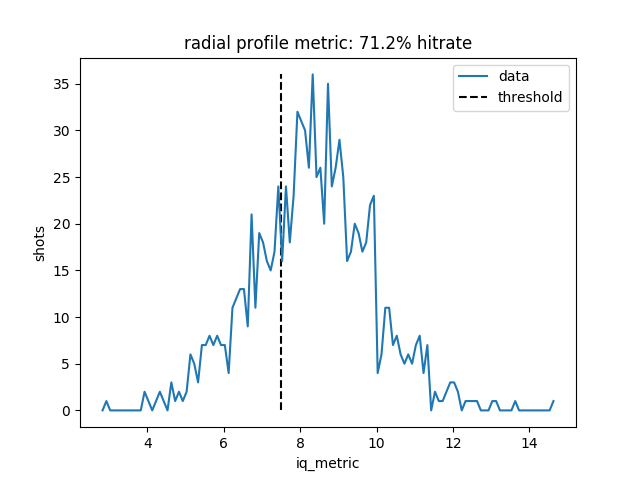

In [83]:
iq_threshold = 7.5
plt.figure()
plt.title('radial profile metric: %.1f%% hitrate' % (100*(iq_metric > iq_threshold).sum()/n_shots))
plt.plot(bin_centers, hy, label='data')
plt.ylabel('shots')
plt.xlabel('iq_metric')
plt.vlines(iq_threshold,0,hy.max(),color='k',linestyles='dashed',label='threshold')
plt.legend()
plt.savefig('%s_radial_profile_hist.png' % img_name)
plt.show()

In [84]:
q = q_scale(r, detector_distance=0.12)
iq_avg = iqs[iq_metric > iq_threshold].mean(axis=0)

<IPython.core.display.Javascript object>


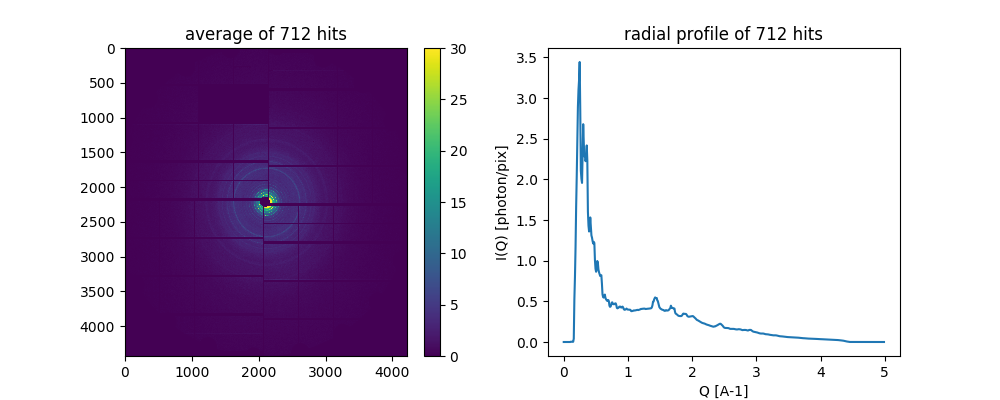

In [85]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('average of %d hits' % (hits))
plt.imshow(avg_img,aspect='auto',clim=[0,30]) #[0,30]
plt.colorbar()

plt.subplot(1,2,2)
plt.title('radial profile of %d hits' % (iq_metric > iq_threshold).sum())
plt.plot(q, iq_avg/9.5)
plt.ylabel('I(Q) [photon/pix]')
plt.xlabel('Q [A-1]')

plt.savefig('%s_2d_hits+radial_profile_avg.png' % img_name)
plt.show()

In [86]:
save_data = {"JF7":{"2D_sum":icorr_sum*n_shots, "2D_sum_hits":avg_img*hits, "num_shots":n_shots, "num_hits":hits, "Q_bins":r, "I_Q":iqs, "I_threshold":iq_threshold}}
save_path = '/sf/bernina/data/p17743/res/work/hdf5/%s.h5'%img_name
save_h5(save_path,save_data)
print('saved data to: %s' % save_path)

saved data to: /sf/bernina/data/p17743/res/work/hdf5/SilverBehenate_powderCalibration.h5


array([  8.57479665,   8.8151209 ,   8.81905513,  10.31797046,
         9.08873471,   8.86025543,   6.25165453,   8.24840729,
         8.74079867,  12.29560517])